# this is a dud as normalised distance is by index not distance

# Interpolate bed surface using my line2line method

Interpolate along track direction, then between tracks in 1D using the same distance from channel peak

1. Normalise each line so that it is zeroed on the peak of the channel.  ie extends in + and - directions
2. Interpolate each line independently to a function.
3. Grid/interpolate over each line. 
4. Linear interpolate between each same index grid point to adjacent lines
5. grid the between line pts



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm

from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points

In [2]:
bed_gdf = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed_depth.shp')

In [3]:
def add_distance_to_gdf(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dx' and 'distance_cum' to the geodataframe
    """
    tmp_dfp = [Point.distance(gdf.geometry.iloc[i]) for i,Point in enumerate(gdf.geometry.iloc[1:])] #note the 1:, equivalent to i+1
    tmp_dfp[:0] = [0]
    gdf['dx'] = pd.Series(tmp_dfp) 
    gdf['distan_cum'] = gdf.dx.cumsum().copy()
    
def add_dDELAYdx(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dDELAY' and 'dDELAYdx' to the geodataframe
    """
    
    gdf['dDELAY'] = gdf.DELAY.diff().copy()
        
    gdf['dDELAYdx'] = gdf.dDELAY.to_numpy()/gdf.dx.to_numpy()

In [4]:
ll = {} #a dictionary of geodataframes of radarlines over KIS2, ie one gdf for each line.

for line in bed_gdf[bed_gdf.camp =='KIS2'].line_name.unique().tolist():
    ll[line] = bed_gdf[(bed_gdf.line_name==line) & (bed_gdf.camp=='KIS2')].copy()
    ll[line].sort_values(by='x',inplace=True)
    ll[line].reset_index(drop=True,inplace=True)
    add_distance_to_gdf(ll[line])
    add_dDELAYdx(ll[line])
    

In [5]:
cross_channel_lines = [ 'line7p75','line7p5', 'lineback2camp','line7p25','line7', 'line6','line5','lineAPREScross','line4']

In [6]:
#lines which cross the channel, (ll restricted to the above subset)
cl  = {key:ll[key] for key in cross_channel_lines}

In [7]:
#channel mins is the same method as in 11_RADAR_profile_possible_channel_locs.ipynb
#its checked there
channel_mins = {key:value.ice_thickn.idxmin() for key,value in cl.items()}

### next do channel edges

In [8]:
# find the point at the edge of each channel, where dDELAYdx is over a certain threshold
channel_edges = {}
for key,value in cl.items():
    channel_edges[key] = [value[abs(value.dDELAYdx) > 20].index[0],
                          value[abs(value.dDELAYdx) > 20].index[-1]] 

In [9]:
channel_edges

{'line7p75': [115, 149],
 'line7p5': [101, 168],
 'lineback2camp': [154, 269],
 'line7p25': [148, 214],
 'line7': [303, 356],
 'line6': [545, 684],
 'line5': [631, 813],
 'lineAPREScross': [416, 648],
 'line4': [711, 869]}

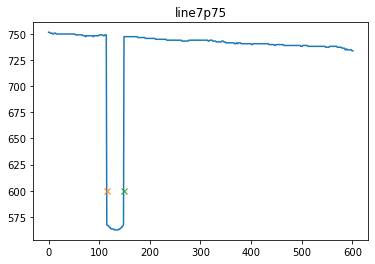

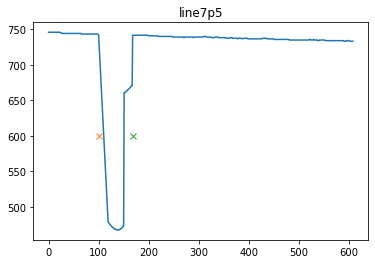

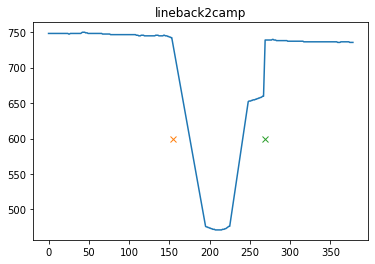

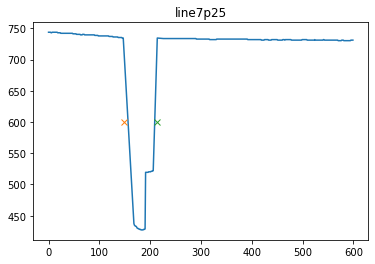

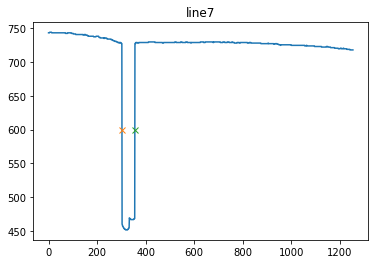

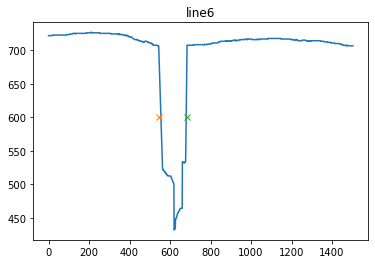

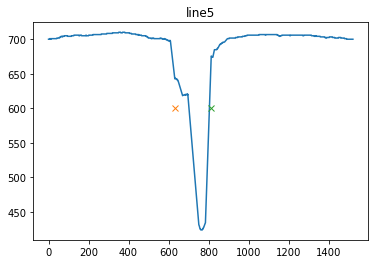

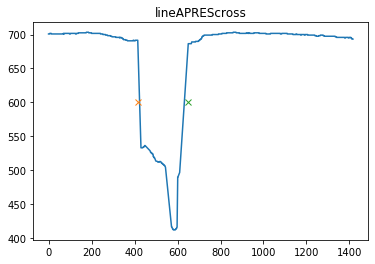

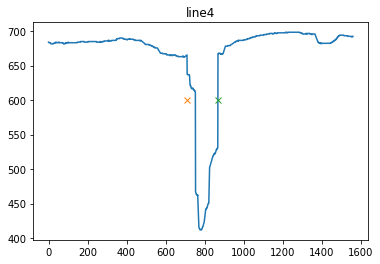

In [10]:
# double check we've picked the right bits.
for key,value in cl.items():
    plt.figure()
    plt.plot(value.ice_thickn)
    plt.plot(channel_edges[key][0],600,'x')
    plt.plot(channel_edges[key][1],600,'x')
    plt.title(key)
    plt.show()

In [11]:
# find the distance from the middle of channel, this isnt used.
for key,value in cl.items():
    ineg1, ipos1 = channel_edges[key] 
    i0 = channel_mins[key]
    
    value['distance_from_midchan'] = value.distan_cum - value.distan_cum.loc[channel_mins[key]]

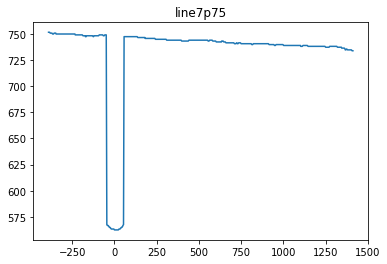

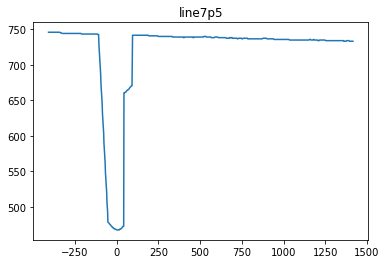

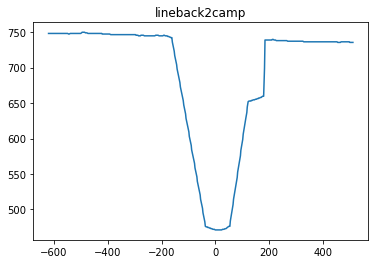

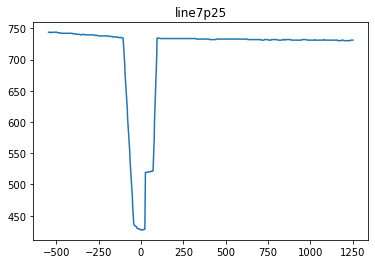

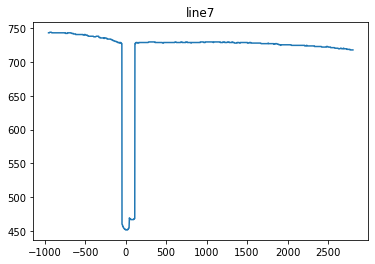

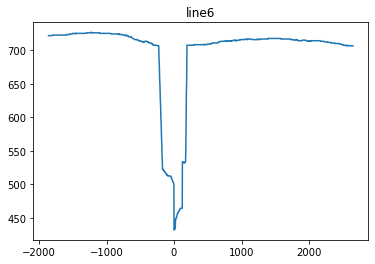

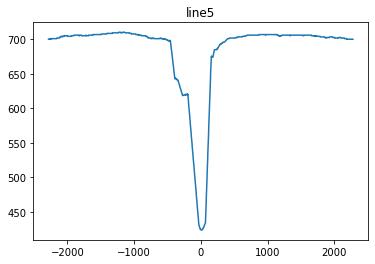

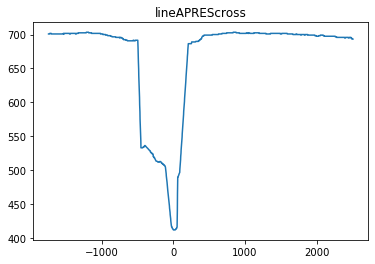

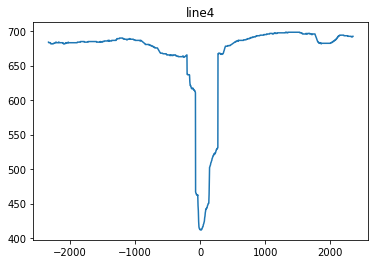

In [12]:
# double check we've picked the right bits.
for key,value in cl.items():
    plt.figure()
    plt.plot(value.distance_from_midchan,value.ice_thickn)
    plt.title(key)
    plt.show()

In [13]:
#this isnt used
#make a df just 400m on each side of the channel

# chan_gdf = {}
# for key,value in cl.items():
#     chan_gdf[key] = cl[key][cl[key].distance_from_midchan.abs() < 500 ]
    
del cl['lineback2camp']

In [14]:
# add 'normalised_dist_from_centre_chan' to cl dataframe

chanpts = {} #left right and mid indexs of points of channel

for key,value in cl.items():
    
    ineg1, ipos1 = channel_edges[key] 
    i0 = channel_mins[key]
    
    chanpts[key] = [ineg1, i0, ipos1]
    
    lhs_chann = np.linspace(-1,0,i0 - ineg1 + 1) #left and including mid of channel
    rhs_chann = np.linspace(0,1,ipos1 - i0 + 1)[1:] #right, not including mid of channel
    value['normalised_dist_from_centre_chan'] = np.nan
    value.normalised_dist_from_centre_chan.iloc[ineg1:ipos1 + 1] = np.hstack([lhs_chann,rhs_chann])    

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


 # bin over each 5m is easier than interpolating 
 
 - Use a new coordinate system where 0 is middle of channel -1 is the left of the channel 1 is the right of the channel (or maybe l & r opposite)
 
  

In [15]:
def bin_chan(gdf):
    """
    Input: Gdf with 'normalised_dist_from_centre_chan' as a column
    
    bin the ice thickness & coordinates in the channel
    
    Output: gdf only over the channel, all variables binned to certain cross channel intervals
    """
    
    bin_size = 0.1 # the channel is 2 units wide. so 0.1 means 20 points accross the channel

    L= 2 #length of line (rounds up to bin size)

    ir = pd.interval_range(-1,1,periods=20) # bin sections

    bins = pd.cut( gdf.normalised_dist_from_centre_chan , bins=ir) #corresponding bins for each point

    bins.rename('channel_bins',inplace=True)

    gdf_out = gdf.groupby(bins).mean().copy()  #average each bin
    gdf_out.reset_index(inplace=True)
    gdf_out['line_name'] = gdf.line_name.iloc[0]

    geometry = [Point(xy) for xy in zip(gdf_out.x,gdf_out.y)]
    gdf_out = gpd.GeoDataFrame(gdf_out,geometry=geometry,crs="EPSG:3031")
    gdf_out['index_over_chan'] = np.linspace(-1,0.9,20).round(decimals = 1)
#     gdf_out.set_index('index_over_chan',inplace=True)
    
    return gdf_out

In [16]:
#for every cross channel line, bin the indicies in the channel

c_grid = {}

for key,value in cl.items():
    c_grid[key] = bin_chan(value)


In [17]:
#vertical slice ( a column) is over one radar line
index_over_chan = np.array([value.index_over_chan.tolist() for value in c_grid.values()]).T
ice_thickn = np.array([value.ice_thickn.tolist() for value in c_grid.values()]).T
points_x = np.array([value.x for value in c_grid.values()]).T
points_y = np.array([value.y for value in c_grid.values()]).T
#[line[0] for line in points] gets one point from each for points

In [18]:
#Draw lines down the channel between points, put new points on the lines 
#ie, linear interpolation between each pair of points.

number_of_new_points = 9 # number_of_new_points to interpolate between existing points
new_length =  number_of_new_points*(ice_thickn.shape[1]-1)+ice_thickn.shape[1]  

ice_thickn_new = np.zeros([ice_thickn.shape[0], new_length])
points_x_new = ice_thickn_new.copy()
points_y_new = ice_thickn_new.copy()

for i in range(ice_thickn.shape[1]-1):
    a = i*(number_of_new_points+1)
    b = i*(number_of_new_points+1)+number_of_new_points+1
    ice_thickn_new[:,a:b] = np.linspace(ice_thickn[:,i],ice_thickn[:,i+1],number_of_new_points+2)[:-1,:].T


    points_x_new[:,a:b] = np.linspace(points_x[:,i],points_x[:,i+1],number_of_new_points+2)[:-1,:].T

    points_y_new[:,a:b] = np.linspace(points_y[:,i],points_y[:,i+1],number_of_new_points+2)[:-1,:].T

ice_thickn_new[:,-1] = ice_thickn[:,-1]
points_x_new[:,-1] = points_x[:,-1]
points_y_new[:,-1] = points_y[:,-1]

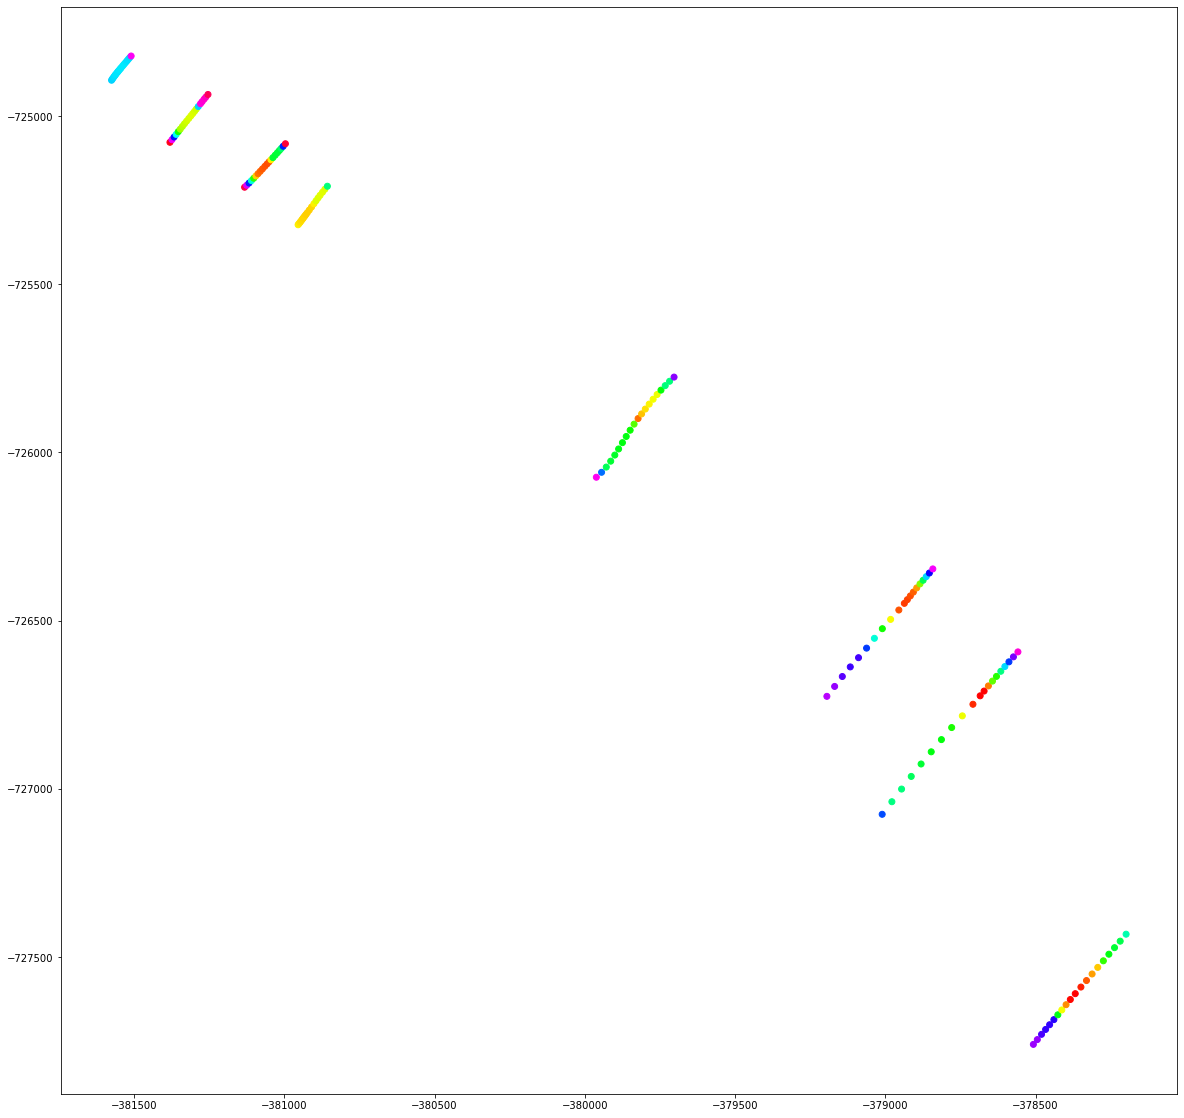

In [19]:
plt.figure(figsize=(20,20))
plt.scatter(points_x,points_y,c=ice_thickn,cmap='hsv')

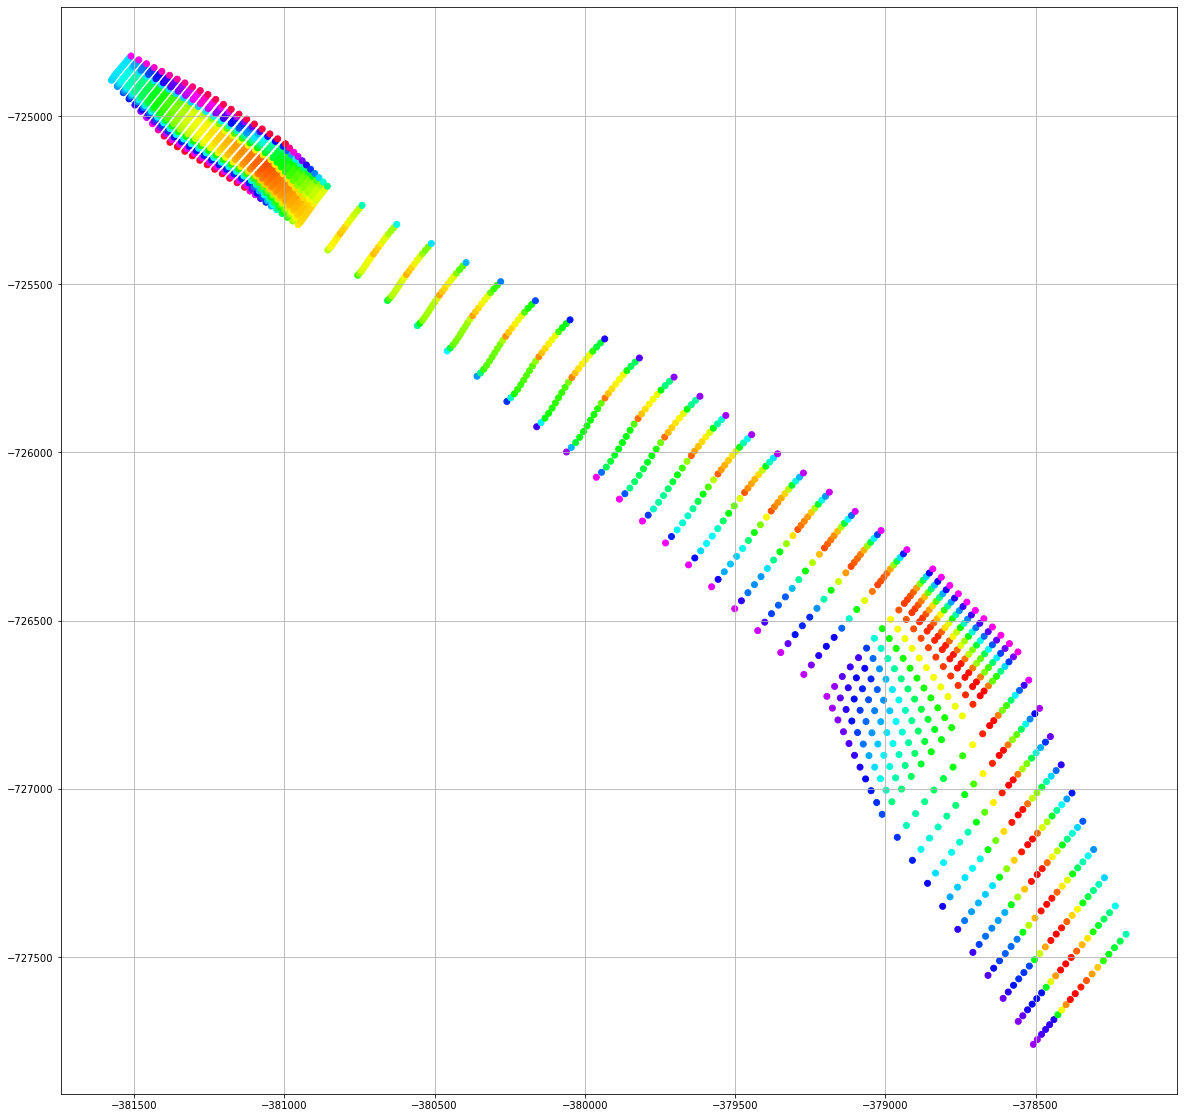

In [20]:
plt.figure(figsize=(20,20))
plt.scatter(points_x_new,points_y_new,c=ice_thickn_new,cmap='hsv')
plt.grid()

In [21]:
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2lineinterp_points_x.npy',points_x_new)
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2lineinterp_points_y.npy',points_y_new)
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2lineinterp_ice_thickn.npy',ice_thickn_new)

In [22]:
gdf = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed_depth.shp')

In [23]:
gdf.line_name.unique()

array(['line7', 'line9', 'line0', 'line10', 'line11', 'line12', 'line13',
       'line14', 'line1', 'line250', 'line2', 'line3', 'line4', 'line500',
       'line6', 'line7p25', 'line7p5', 'line7p75', 'line8',
       'lineAPREScross', 'lineAPRESdown', 'lineback2camp', 'linedownchan',
       'lineend', 'linen250', 'linen500', 'lineseis12', 'lineseis34',
       'lineseis56', 'linestart', 'lineupchan', 'line0KIS1', 'left02',
       'left1011', 'left1213', 'left1415', 'left35', 'left46', 'left79',
       'left810', 'right1112', 'right1314', 'right13', 'right24',
       'right68', 'right910', 'line5'], dtype=object)

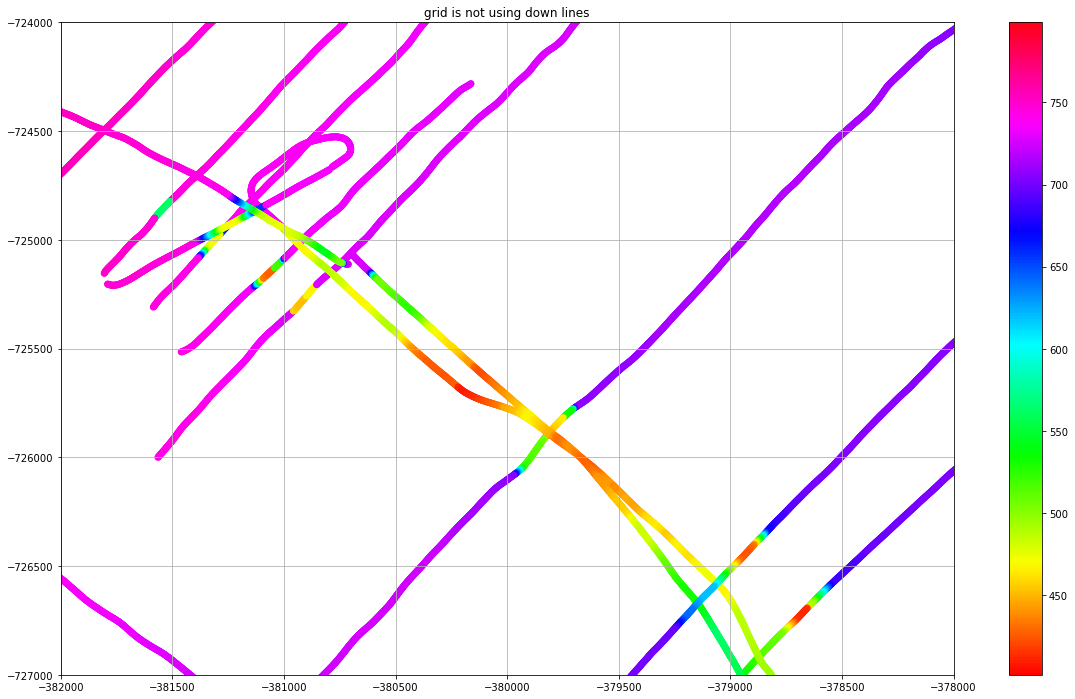

In [24]:
# radar
plt.figure(figsize=(20,12))

plt.scatter( gdf.x,gdf.y,c=gdf.ice_thickn,cmap='hsv')
plt.colorbar()
plt.title('grid is not using down lines')
plt.xlim([-382000, -378000])
plt.ylim([-727000,-724000])
plt.grid()
plt.show()

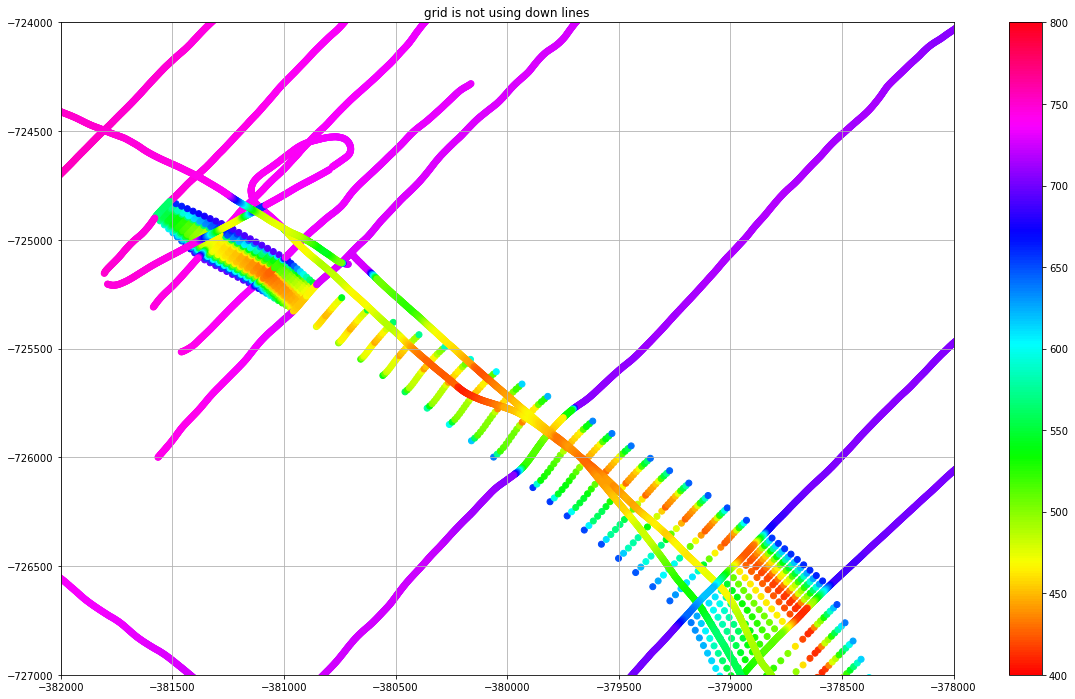

In [30]:

# radar
plt.figure(figsize=(20,12))
plt.scatter(points_x_new,points_y_new,c=ice_thickn_new,cmap='hsv',vmin=400, vmax=800)
plt.scatter( gdf.x,gdf.y,c=gdf.ice_thickn,cmap='hsv',vmin=400, vmax=800)
plt.colorbar()
plt.title('grid is not using down lines')
plt.xlim([-382000, -378000])
plt.ylim([-727000,-724000])
plt.grid()
plt.show()

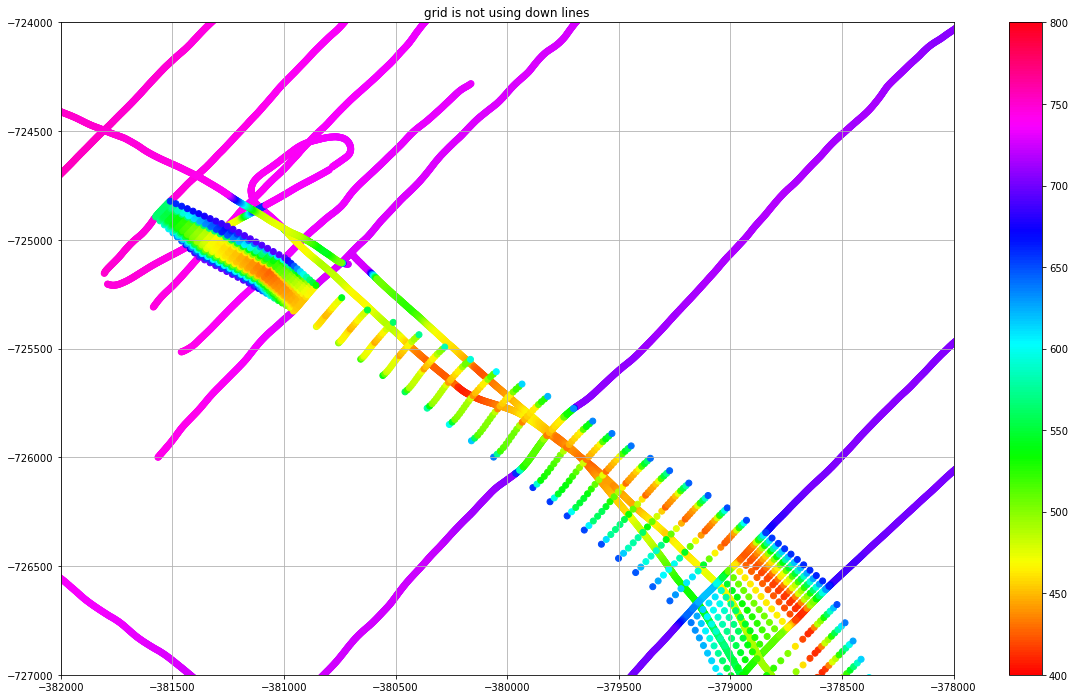

In [31]:

# radar
plt.figure(figsize=(20,12))

plt.scatter( gdf.x,gdf.y,c=gdf.ice_thickn,cmap='hsv',vmin=400, vmax=800)
plt.scatter(points_x_new,points_y_new,c=ice_thickn_new,cmap='hsv',vmin=400, vmax=800)
plt.colorbar()
plt.title('grid is not using down lines')
plt.xlim([-382000, -378000])
plt.ylim([-727000,-724000])
plt.grid()
plt.show()

In [20]:
# # I think do this differently, just split the area between two points into many points  then assign them depths, dont bother with all this re-indexing

# distan_cums = np.empty([20,len(c_grid)]) #cumulative distance down the channel
# distan_cums[:] = np.nan

# for i in range(20): #accross the 20 points that cross each channel path

#     dx = [Point.distance(gdf.geometry.iloc[i]) for i,Point in enumerate([line[i] for line in points][1:])] #note the 1:, equivalent to i+1
#     dx[:0] = [0]
#     distan_cum = np.cumsum(dx)
#     distan_cums[i,:] = distan_cum
    
# distan_cums = distan_cums

# #####

# down_chan = np.arange(0,len(c_grid))

# down_chan_new = np.linspace(0,len(c_grid) - 1,(len(c_grid)-1)*100)

# ice_thickn_new = np.empty([20,(len(c_grid)-1)*100])

# for i in range(20):
#     f = sp.interpolate.interp1d(down_chan, ice_thickn[i,:])
#     ice_thickn_new[i,:] = f(down_chan_new)

In [231]:
# I think do this differently, just split the area between two points into many points  then assign them depths, dont bother with all this re-indexing

In [ ]:
for i in range():

In [230]:
ice_thickn_new

array([[566.76493558, 568.10636107, 569.44778655, ..., 637.07318025,
        637.01739028, 636.96160031],
       [566.76493558, 567.62106015, 568.47718472, ..., 635.90106884,
        635.89703926, 635.89300968],
       [565.9203742 , 566.29923265, 566.6780911 , ..., 621.52860045,
        621.50323651, 621.47787257],
       ...,
       [565.07579906, 566.08169825, 567.08759744, ..., 521.05290025,
        520.57841856, 520.10393688],
       [566.34265489, 567.36120504, 568.37975518, ..., 525.47628364,
        524.62176252, 523.7672414 ],
       [657.43589969, 657.74253605, 658.04917241, ..., 545.41738245,
        544.29904085, 543.18069925]])

In [207]:
np.linspace(0,len(c_grid),20)

array([0.        , 0.36842105, 0.73684211, 1.10526316, 1.47368421,
       1.84210526, 2.21052632, 2.57894737, 2.94736842, 3.31578947,
       3.68421053, 4.05263158, 4.42105263, 4.78947368, 5.15789474,
       5.52631579, 5.89473684, 6.26315789, 6.63157895, 7.        ])

In [179]:
distan_cums = np.empty(20)
distan_cums[:] = np.nan


In [180]:
distan_cums

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan])

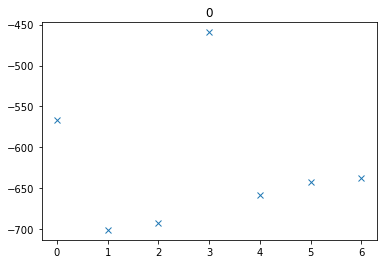

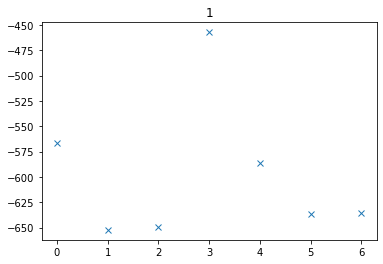

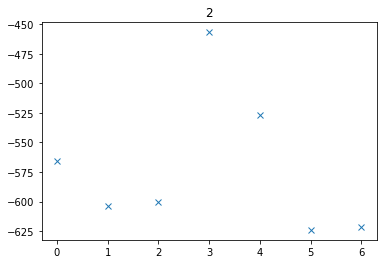

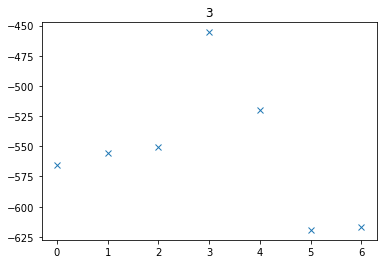

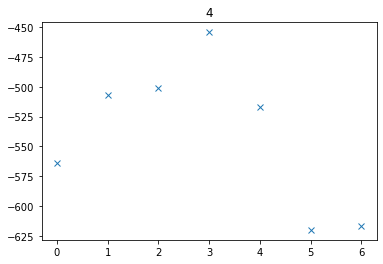

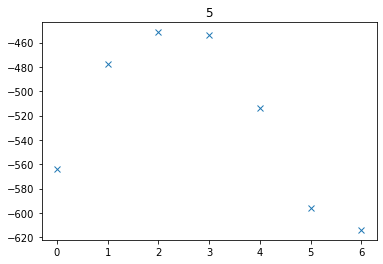

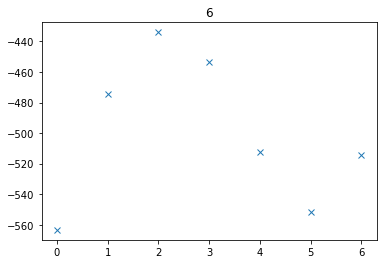

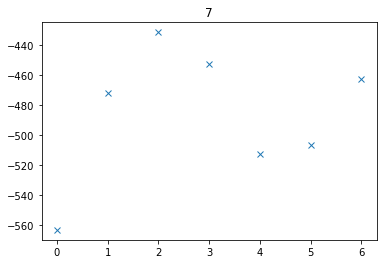

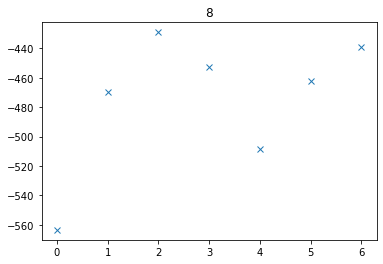

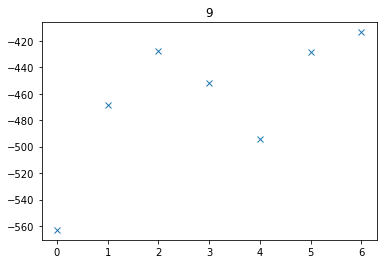

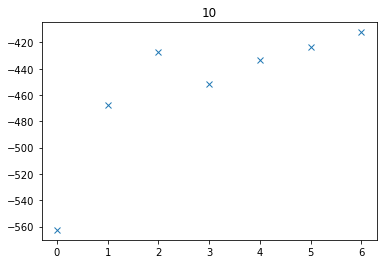

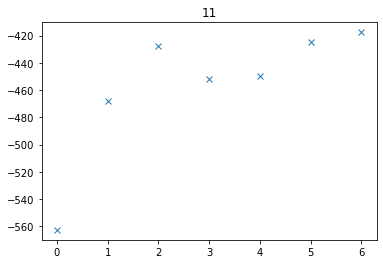

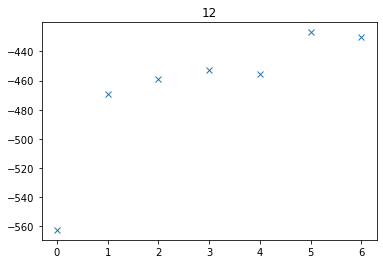

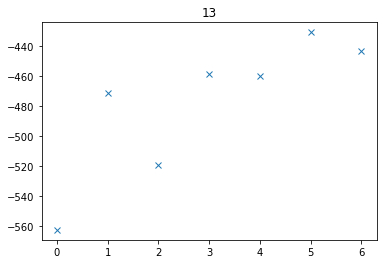

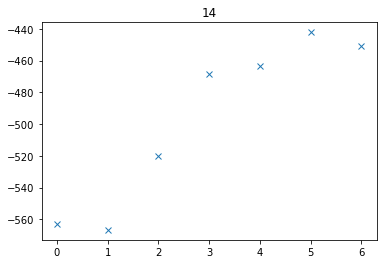

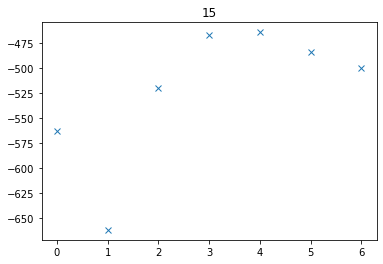

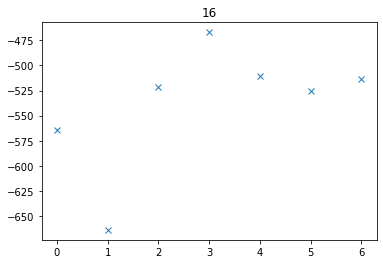

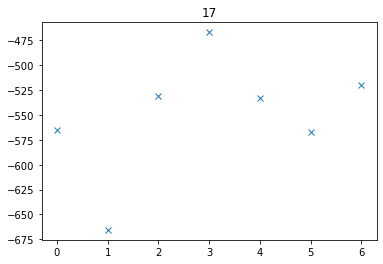

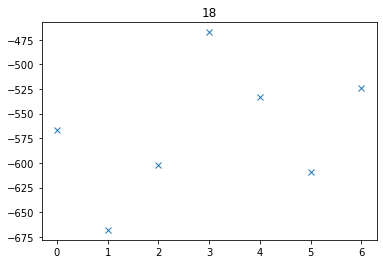

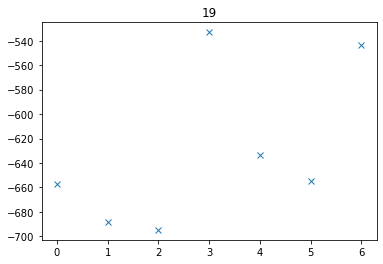

In [146]:
for i in range(20):
    plt.figure()
    plt.plot(-ice_thickn[i,:],'x')
    plt.title(i)
    plt.show()


In [149]:
c_grid['line7']

,channel_bins,x,y,DELAY,SEQnum,ice_thickn,dx,distan_cum,dDELAY,dDELAYdx,distance_from_midchan,normalised_dist_from_centre_chan,line_name,geometry,index_over_chan
0,"(-1.0, -0.9]",-380954.300000,-725323.500000,5430.000000,1.0,459.369757,4.951767,912.744577,-10.000000,-2.019481,-40.933500,-0.933333,line7,POINT (-380954.300 -725323.500),-1.0
1,"(-0.9, -0.8]",-380952.050000,-725320.950000,5405.000000,1.0,457.252263,2.267157,916.145312,-15.000000,-6.616216,-37.532765,-0.833333,line7,POINT (-380952.050 -725320.950),-0.9
2,"(-0.8, -0.7]",-380948.500000,-725317.000000,5400.000000,1.0,456.828749,4.177320,921.456210,0.000000,0.000000,-32.221867,-0.733333,line7,POINT (-380948.500 -725317.000),-0.8
3,"(-0.7, -0.6]",-380946.400000,-725314.650000,5385.000000,1.0,455.558152,2.159733,924.608415,-10.000000,-4.660728,-29.069661,-0.633333,line7,POINT (-380946.400 -725314.650),-0.7
4,"(-0.6, -0.5]",-380942.900000,-725310.500000,5370.000000,1.0,454.287502,4.263801,930.039478,-10.000000,-2.345325,-23.638599,-0.533333,line7,POINT (-380942.900 -725310.500),-0.6
5,"(-0.5, -0.3999999999999999]",-380940.100000,-725307.100000,5365.000000,1.0,453.863934,3.303407,934.444021,-5.000000,-1.135192,-19.234056,-0.433333,line7,POINT (-380940.100 -725307.100),-0.5
6,"(-0.3999999999999999, -0.29999999999999993]",-380937.400000,-725303.800000,5360.000000,1.0,453.440366,2.061553,938.707846,0.000000,0.000000,-14.970231,-0.333333,line7,POINT (-380937.400 -725303.800),-0.4
7,"(-0.29999999999999993, -0.19999999999999996]",-380934.600000,-725300.500000,5350.000000,1.0,452.593204,3.227165,943.036146,-5.000000,-2.270383,-10.641930,-0.233333,line7,POINT (-380934.600 -725300.500),-0.3
8,"(-0.19999999999999996, -0.09999999999999998]",-380931.700000,-725297.200000,5350.000000,1.0,452.593204,2.267157,947.429332,0.000000,0.000000,-6.248744,-0.133333,line7,POINT (-380931.700 -725297.200),-0.2
9,"(-0.09999999999999998, 0.0]",-380928.350000,-725293.150000,5345.000000,1.0,452.169609,3.124372,952.685605,-5.000000,-2.518964,-0.992472,-0.033333,line7,POINT (-380928.350 -725293.150),-0.1


In [99]:
for i in range(20):
    f = interpolate.interp1d(x, ice_thickn[i,:])
    xnew = np.arange(0, 9, 0.1)

array([[642.5312992 , 642.5312992 , 642.5312992 , 642.5312992 ,
        642.5312992 , 642.5312992 , 642.5312992 ],
       [636.29529631, 636.29529631, 636.29529631, 636.29529631,
        636.29529631, 636.29529631, 636.29529631],
       [624.01003939, 624.01003939, 624.01003939, 624.01003939,
        624.01003939, 624.01003939, 624.01003939],
       [619.23304076, 619.23304076, 619.23304076, 619.23304076,
        619.23304076, 619.23304076, 619.23304076],
       [619.97299153, 619.97299153, 619.97299153, 619.97299153,
        619.97299153, 619.97299153, 619.97299153],
       [596.16566911, 596.16566911, 596.16566911, 596.16566911,
        596.16566911, 596.16566911, 596.16566911],
       [551.61094204, 551.61094204, 551.61094204, 551.61094204,
        551.61094204, 551.61094204, 551.61094204],
       [507.00785933, 507.00785933, 507.00785933, 507.00785933,
        507.00785933, 507.00785933, 507.00785933],
       [462.35709092, 462.35709092, 462.35709092, 462.35709092,
        462.3570

In [ ]:
def bin_mean(gdf,bin_size = 5):
    """
    Input: gdf of a line,
    Output: gdf of the line spatially binned and averaged every bin_size
    ie each point is put into a spatial bin. Each spatial bin is averaged over for all variables
    """
    
    line_name = gdf.line_name
    line_name = gdf.camp
    line_name = gdf.line_name
    
    L= -(- gdf.distan_cum.iloc[-1] // bin_size)*bin_size #length of line (rounds up to bin size)
    
    ir = pd.interval_range(0,L,freq=bin_size) # bin sections

    bins = pd.cut( gdf.distan_cum , bins=ir) #corresponding bins for each point
    
    bins.rename('distance_bins',inplace=True)
    
    gdf_out = gdf.groupby(bins).mean().copy()  #average each bin
    gdf_out.reset_index(inplace=True)
    
    gdf_out['line_name'] = gdf.line_name.iloc[0]
    gdf_out['camp'] = gdf.camp.iloc[0]
    
    geometry = [Point(xy) for xy in zip(gdf_out.x,gdf_out.y)]
    gdf_out = gpd.GeoDataFrame(gdf_out,geometry=geometry,crs="EPSG:3031")
    
    return gdf_out 


In [18]:
cl['line5'].normalised_dist_from_centre_chan

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1517   NaN
1518   NaN
1519   NaN
1520   NaN
1521   NaN
Name: ichan, Length: 1522, dtype: float64

In [ ]:
ipos1 - ineg1 +1 #length

In [ ]:
cl['line7'].iloc[ineg1:ipos1].shape

Username for 'https://git.geo.vuw.ac.nz': ^C
